## Итоговый проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

### 1. Подключение библиотек и скриптов

In [441]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler

from lightgbm import LGBMRegressor


In [442]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

### 2. Пути к директориям и файлам

In [443]:
TRAIN_DATASET_PATH = './input data/train.csv'
TEST_DATASET_PATH = './input data/test.csv'

### 3. Описание датасета
**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности

**Social_1**, **Social_2**, **Social_3** - социальные показатели местности

**Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры


### 4. Загрузка данных

In [444]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id')

df_train.shape, df_test.shape

((10000, 19), (5000, 18))

In [445]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [446]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


### 5. Приведение типов

In [447]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [448]:
df_test.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [449]:
# Оставил про запас. С этим преобразованием метрика ниже
#df_train['DistrictId'] = df_train['DistrictId'].astype(str)
#df_test['DistrictId'] = df_test['DistrictId'].astype(str)

### 6. Получение информации о данных df_train (EDA)

In [450]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

Можно отметить, что:
- есть пропуски в LifeSquare
- есть пропуски в Healthcare_1
- большая часть полей типа float64, но так же есть поля типа int64 и object

In [451]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

Аналогичная ситуация:
- есть пропуски в LifeSquare
- есть пропуски в Healthcare_1
- большая часть полей типа float64, но так же есть поля типа int64 и object

Статистика по всем количественным столбцам

In [452]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [453]:
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,"5,000.00","5,000.00","5,000.00","3,959.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","2,623.00","5,000.00","5,000.00"
mean,51.28,1.91,56.45,36.16,5.98,8.63,12.60,"1,984.39",0.12,24.93,"5,406.90",8.26,"1,146.66",1.32,4.24
std,44.18,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,"4,026.61",23.86,"1,044.74",1.48,4.78
min,0.00,0.00,1.38,0.33,0.00,1.00,0.00,"1,908.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,21.00,1.00,41.91,23.09,1.00,4.00,9.00,"1,973.00",0.02,6.00,"1,564.00",0.00,325.00,0.00,1.00
50%,37.00,2.00,52.92,32.93,6.00,7.00,12.00,"1,977.00",0.07,25.00,"5,285.00",2.00,900.00,1.00,3.00
75%,77.00,2.00,66.29,45.17,9.00,12.00,17.00,"2,000.00",0.20,36.00,"7,287.00",5.00,"1,548.00",2.00,6.00
max,212.00,17.00,223.45,303.07,620.00,78.00,99.00,"2,020.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00


Статистика по всем категориальным столбцам

In [454]:
df_train.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [455]:
df_test.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000
unique,2,2,2
top,B,B,B
freq,4952,4851,4588


In [456]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [457]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [458]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Заменим текстовые значения признаков Ecology_2, Ecology_3 и Shops_2 бинарными значениями.

In [459]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[feature_bin_names] = df_train[feature_bin_names].replace({'A' :0, 'B' :1})
df_test[feature_bin_names] = df_test[feature_bin_names].replace({'A' :0, 'B' :1})

Оценим взаимосвязь признаков

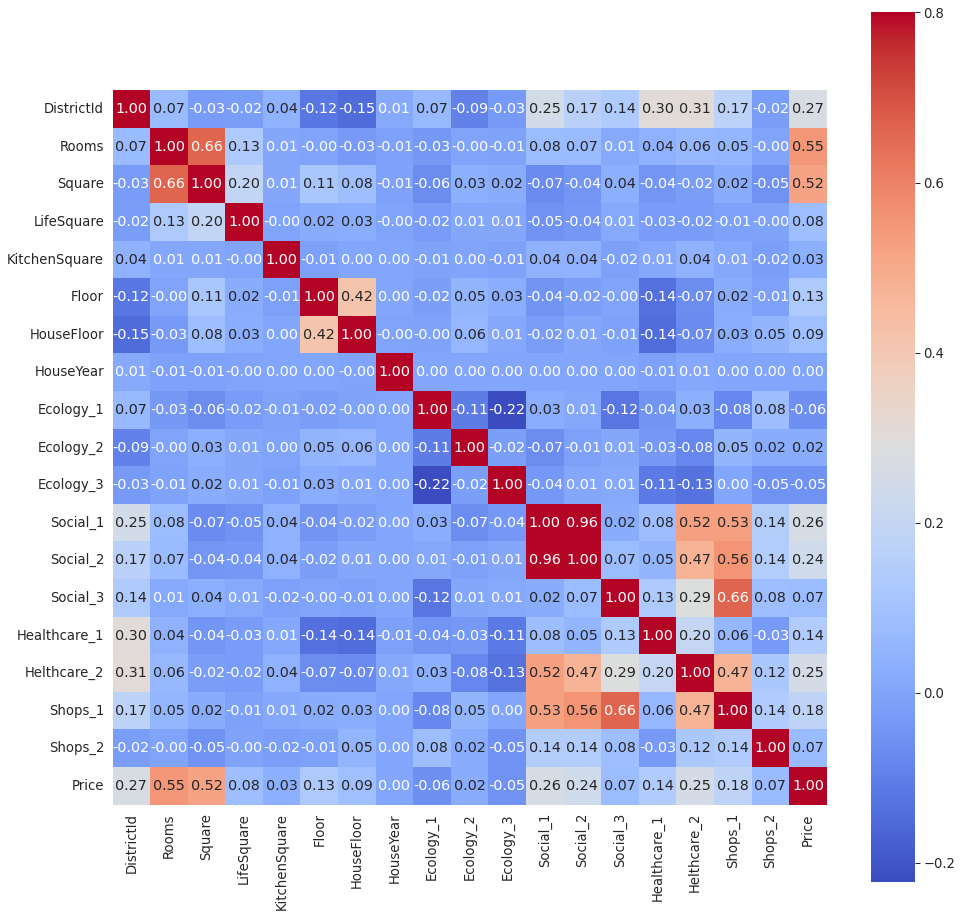

In [460]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

Можно заметить, что целевая переменная Price не сильно коррелирует с признаками, за исключением, наверное, Rooms и Square.

Оценим распределение параметров

array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Ecology_2'}>,
        <AxesSubplot:title={'center':'Ecology_3'}>,
        <AxesSubplot:title={'center':'Social_1'}>],
       [<AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>],
       [<AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Shops_2'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],


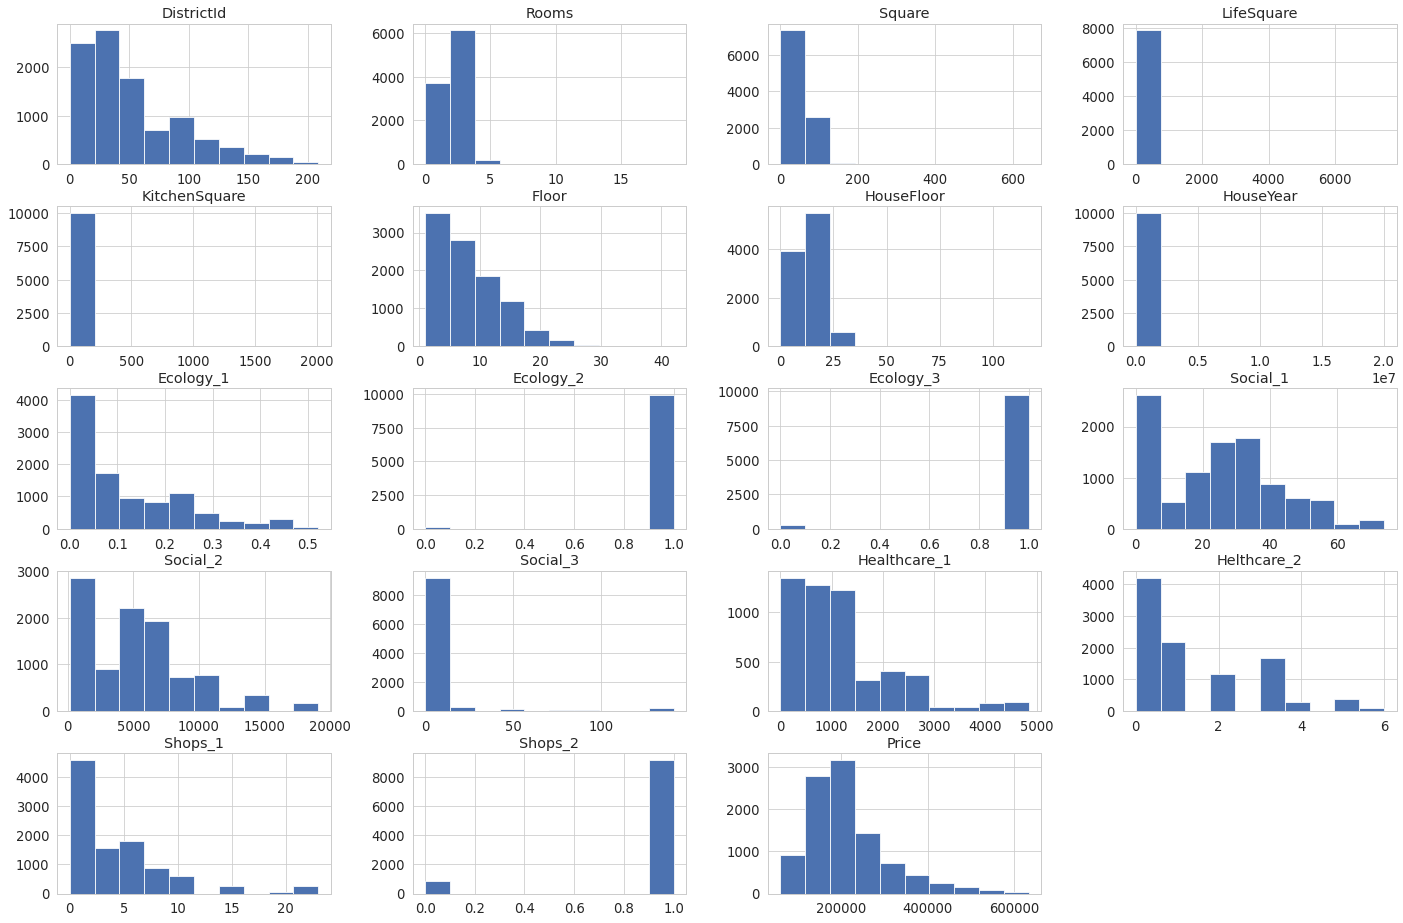

In [461]:
df_train.hist(figsize=(24,16))

Можно предположить о наличии выбросов в следующих признаках:
Room
Square
LifeSquare
KitchenSquare
Floor
HouseFloor
HouseYear
Social_3

#### Целевая переменная

<Figure size 1800x720 with 0 Axes>

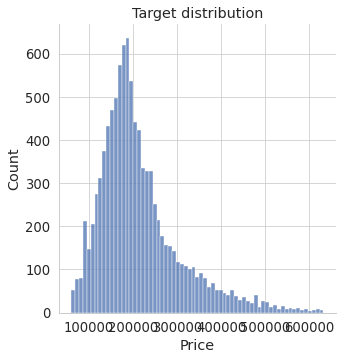

In [462]:
plt.figure(figsize = (25, 10))

sns.displot(df_train['Price'])
plt.title('Target distribution');

### 3. Очистка данных и устранение пропусковии

Работу буду проводить над копиями признаков, сохранив оригинальные на всякий случай

In [463]:
# Новые столбцы в train
df_train['LS_corr'] = df_train['LifeSquare'].copy()
df_train['Square_corr'] = df_train['Square'].copy()

In [464]:
# Новые столбцы в test
df_test['LS_corr'] = df_test['LifeSquare'].copy()
df_test['Square_corr'] = df_test['Square'].copy()

In [465]:
#df_train

Определение количества пропусков в датасете

In [466]:
total = df_train.isnull().sum().sort_values(ascending=False)
percentage = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head()

,Total,Persent
Healthcare_1,4798,47.98
LS_corr,2113,21.13
LifeSquare,2113,21.13
DistrictId,0,0.00
Social_1,0,0.00


In [467]:
total_test = df_test.isnull().sum().sort_values(ascending=False)
percentage = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head()

,Total,Persent
Healthcare_1,4798,47.54
LS_corr,2113,20.82
LifeSquare,2113,20.82
DistrictId,0,0.00
Social_1,0,0.00


Вывод: Для train имеем два признака с пропусками: LifeSquare - 21,13% и Healthcare_1 - 47,98%.
Для test ситуация аналогичная 20,82% и 47,54%, соответственно.
Произведем работу над ними.
Будем проводить аналитику над train и повторять итоговые действия в test.

#### Healthcare_1

В данном признаке почти 48% пропусков. Возможно его заполнение, например медианными значениями или удаление признака полностью.
Попытки его заполнения привели к ухудшению метрики. Поэтому принял решение его удалить из train и test.

In [468]:
if 'Healthcare_1' in df_train.columns:
    df_train.drop('Healthcare_1', axis=1, inplace=True)

if 'Healthcare_1' in df_test.columns:
    df_test.drop('Healthcare_1', axis=1, inplace=True)

#### LifeSquare


In [469]:
df_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']].describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,"10,000.00",1.89,0.84,0.00,1.00,2.00,2.00,19.00
Square,"10,000.00",56.32,21.06,1.14,41.77,52.51,65.90,641.07
LifeSquare,"7,887.00",37.20,86.24,0.37,22.77,32.78,45.13,"7,480.59"
KitchenSquare,"10,000.00",6.27,28.56,0.00,1.00,6.00,9.00,"2,014.00"


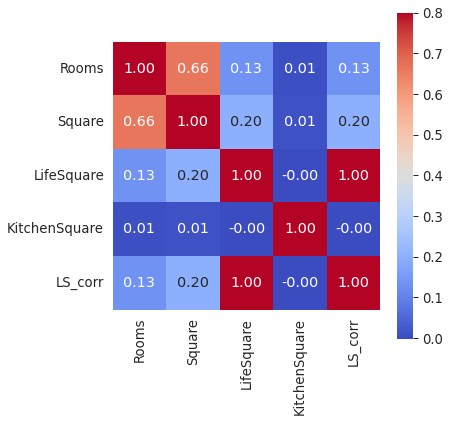

In [470]:
corrmat2 = df_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'LS_corr']].corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat2, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

Не смотря на логичность корреляции 'LifeSquare' с признаками 'Rooms', 'Square', 'KitchenSquare', по факту она почти отсутсвует.

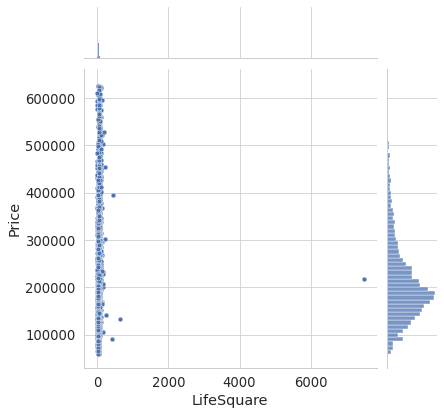

In [471]:
sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='scatter', height=6);

In [472]:
df_train.loc[df_train['LS_corr'] < 0.86, 'LS_corr'] *= 100
df_train.loc[((df_train['LS_corr'] >= 0.86) & (df_train['LS_corr'] <= 10)), 'LS_corr'] *= 10
df_train.loc[((df_train['LS_corr'] > 250) & (df_train['LS_corr'] <= 500)), 'LS_corr'] /= 10
df_train.loc[df_train['LS_corr'] > 250, 'LS_corr'] /= 100

df_test.loc[df_test['LS_corr'] < 0.86, 'LS_corr'] *= 100
df_test.loc[((df_test['LS_corr'] >= 0.86) & (df_test['LS_corr'] <= 10)), 'LS_corr'] *= 10
df_test.loc[((df_test['LS_corr'] > 250) & (df_test['LS_corr'] <= 500)), 'LS_corr'] /= 10
df_test.loc[df_test['LS_corr'] > 250, 'LS_corr'] /= 100

In [473]:
#sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='scatter', height=6);

#### Square

In [474]:
df_train.loc[df_train['Square_corr'] < 10, 'Square_corr'] *= 10
df_train.loc[df_train['Square_corr'] > 300, 'Square_corr'] /= 10

df_test.loc[df_test['Square_corr'] < 10, 'Square_corr'] *= 10
df_test.loc[df_test['Square_corr'] > 300, 'Square_corr'] /= 10

In [475]:
df_train

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LS_corr,Square_corr
Id,,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,0,11,1,"184,966.93",29.44,47.98
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,1,16,1,"300,009.45",40.05,65.68
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,1,3,1,"220,925.91",29.20,44.95
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,0,5,1,"175,616.23",52.73,53.35
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,2,4,1,"150,226.53",23.78,39.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.00,50.40,30.48,5.00,6,5.00,1968,0.14,1,1,46,7960,6,3,11,1,"196,684.32",30.48,50.40
6159,18,1.00,41.52,20.54,9.00,13,13.00,2000,0.00,1,1,30,5562,0,0,5,0,"189,050.29",20.54,41.52
5123,27,1.00,47.94,NaN,1.00,12,16.00,2015,0.07,1,1,2,629,1,0,0,0,"159,143.81",NaN,47.94


### 9. Построение моделей

Возможные дополнительные модели
RandomForestRegressor
CatBoostRegressor

#### Отбор признаков

In [476]:
feature_names = df_train.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LS_corr',
 'Square_corr']

In [477]:
target_name = ['Price']
feature_names =\
    ['DistrictId',
     'Rooms',
#     'Square',
     'Square_corr',
#     'LifeSquare',
     'LS_corr',
     'KitchenSquare',
     'Floor',
     'HouseFloor',
     'HouseYear',
     'Ecology_1',
     'Ecology_2',
     'Ecology_3',
     'Social_1',
     'Social_2',
     'Social_3',
#     'Healthcare_1',
     'Helthcare_2',
     'Shops_1',
     'Shops_2',
#     'Price'
]


In [478]:
X = df_train[feature_names]
y = df_train[target_name]

In [479]:
len(feature_names)

17

#### LGBMRegressor

In [480]:
#corrmat = X.corr()
#№f, ax = plt.subplots(figsize=(16, 16))
#sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

In [481]:
lgbm_model = LGBMRegressor(max_depth=7,
                           n_estimators=100,
                           random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

lgbm_model.fit(X, y)

cv_score = cross_val_score(lgbm_model, X, y,
                           scoring='r2',
                           cv=kf)
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.5f} +- {:.5f}'.format(mean, std))
# R2: 0.74948 +- 0.01985 - исходный ДС
# R2: 0.74959 +- 0.02126 - если исправить 'Healthcare_1' методом fillna
# R2: 0.75002 +- 0.01787 - без 'Healthcare_1'
# R2: 0.74723 +- 0.01917 - c оптимизацией LS по старому
# R2: 0.75002 +- 0.01787 - без оптимизации LS

R2: 0.74968 +- 0.01836


#### Отбор признаков методом RFE

In [482]:
# не запускать без надобности (долго)
for n in range(10, 17, 1):
    rfe = RFE(lgbm_model, n_features_to_select=n, step=1)
    X_ref = rfe.fit_transform(X, y)
    scores = cross_val_score(lgbm_model, X_ref, y, scoring='r2', cv=kf)
    print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean()))

n_features_to_select: 10 - R2: 0.74731
n_features_to_select: 11 - R2: 0.74662
n_features_to_select: 12 - R2: 0.74734
n_features_to_select: 13 - R2: 0.74809
n_features_to_select: 14 - R2: 0.74923
n_features_to_select: 15 - R2: 0.74753
n_features_to_select: 16 - R2: 0.74881


rfe = RFE(estimator=lgbm_model,
          n_features_to_select=14,
          step=2)

rfe.fit(X, y)
X.columns[rfe.support_]

X_ref = rfe.transform(X)
scores = cross_val_score(lgbm_model, X_ref, y, scoring='r2', cv=kf)
print('R2: %.5f' % scores.mean())

#### Настройка гиперпараметров модели

In [483]:
params = {'n_estimators':[100, 150, 200, 250],
         'max_depth':[5, 6, 7, 8, 9]}

In [493]:
lgbm_model_grid = GridSearchCV(lgbm_model, params, scoring='r2',
                           cv=kf,
                           n_jobs=-1)
lgbm_model_grid.fit(X_ref, y.values.ravel())
print(lgbm_model_grid.best_params_)
print('R2 на train: {:.5f}'.format(lgbm_model_grid.best_score_))

{'max_depth': 6, 'n_estimators': 200}
R2 на train: 0.75130


{'max_depth': 10, 'n_estimators': 150} R2 на train: 0.75362 - на всех данных без каких либо изменений
{'max_depth': 10, 'n_estimators': 150} R2 на train: 0.74756 - если исправить 'Healthcare_1' методом fillna
{'max_depth': 8, 'n_estimators': 200} R2 на train: 0.75182 - без 'Healthcare_1'
{'max_depth': 8, 'n_estimators': 200} R2 на train: 0.75198 - c оптимизацией LS по старому
{'max_depth': 8, 'n_estimators': 150} R2 на train: 0.75252 - без оптимизации LS
{'max_depth': 6, 'n_estimators': 200} R2 на train: 0.75251- с оптимизацией Square

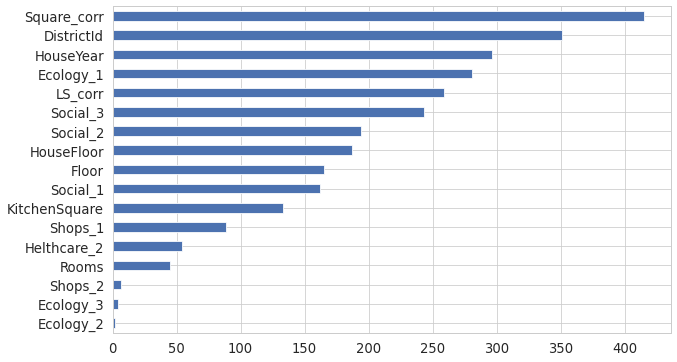

In [485]:
lgbm_model.fit(X, y)
importances = lgbm_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(10, 6));

In [486]:
feature_importances = pd.DataFrame(zip(X.columns, lgbm_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square_corr,415
0,DistrictId,351
7,HouseYear,296
8,Ecology_1,281
3,LS_corr,259
13,Social_3,243
12,Social_2,194
6,HouseFloor,187
5,Floor,165
11,Social_1,162


#### CatBoostRegressor

In [487]:
%%time
parameters = {'silent': True,
              'learning_rate': 0.023,
              'iterations': 1005,
              'eval_metric': 'R2',
              'depth': 10,
              'allow_writing_files': False}

CBR_model = CatBoostRegressor(**parameters)

CBR_model.fit(X, y)

cv_score = cross_val_score(CBR_model, X, y,
                           scoring='r2',
                           cv=KFold(n_splits=5,
                                    shuffle=True,
                                    random_state=42,
                                    ))
print('R2: {:.4f} +- {:.4f}'.format(cv_score.mean(), cv_score.std()))

R2: 0.7591 +- 0.0172
CPU times: user 4min 3s, sys: 10.2 s, total: 4min 13s
Wall time: 43.9 s


R2: 0.7577 +- 0.0169 - без оптимизации LS
R2: 0.7562 +- 0.0182 - с оптимизацией LS по старому
R2: 0.7575 +- 0.0158 - с оптимизацией Square
R2: 0.7591 +- 0.0172 - оптимизация Square b LS по старому

### 10. Прогнозирование на тестовом датасете

для lgbm_model
feature_imp_list = feature_importances.nlargest(13, 'importance')['feature_name'].to_list()
#final_model = lgbm_model_grid
final_model = LGBMRegressor(max_depth=7,
                            n_estimators=100,
                            random_state=42)
final_model.fit(df_train[feature_imp_list], y)
y_pred = final_model.predict(df_test[feature_imp_list])
preds['Price'] = y_pred
preds.head()

preds

Пример итоговых данных 2го места (0.77828)
	Id	Price
0	725	162769.921327
1	15856	215636.872322
2	5480	247221.658929
3	15664	337349.183679
4	14275	148225.992027

Пример итоговых данных 3го места (0.77605)
      Id          Price
0    725  160532.890434
1  15856  231610.043178
2   5480  237992.530775
3  15664  303712.131281
4  14275  137062.281720

In [488]:
feature_imp_list = feature_importances.nlargest(27, 'importance')['feature_name'].to_list()

y_pred = CBR_model.predict(df_test[feature_imp_list])
preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"163,433.94"
1,15856,"216,938.31"
2,5480,"205,520.86"
3,15664,"360,097.64"
4,14275,"141,122.78"


In [489]:
#preds

In [490]:
#preds.to_csv('my_submission_12_3.csv', index=False)

#### Примечание:
На изначальных данных без каких либо вмешательств, в т.ч. работы с пропусками результаты следующие - train 0.75362 и 0.74153 на Public Leaderboard. Можно предположить, что модель сама неплохо справляется с выбросами и гряздными значениями. Следовательно, наша задача ей особо не мешать, а только помогать :)
Без 'Healthcare_1' метрика лучше
Корректировка Жилой площади, как делал ранее улучшает метрику на 0,001 и сильно изменяет коррекляцию м/у площадьми
